In [97]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ijson
import seaborn as sns

In [98]:
def compute_speed(timestamps, x_positions, y_positions):
    """
    Computes speed in km/h from position and time data.

    Args:
        timestamps (np.ndarray): Array of timestamps in seconds.
        x_positions (np.ndarray): Array of x positions in meters.
        y_positions (np.ndarray): Array of y positions in meters.

    Returns:
        np.ndarray: Speed in km/h.
    """
    time_diffs = np.diff(timestamps)
    time_diffs[time_diffs == 0] = np.nan  # Avoid division by zero
    
    dx = np.diff(x_positions)
    dy = np.diff(y_positions)
    displacements = np.sqrt(dx**2 + dy**2)  # Euclidean distance

    speeds = displacements / time_diffs  # m/s
    speeds *= 3.6  # Convert to km/h

    return np.insert(speeds, 0, np.nan)  # Align size by inserting NaN at the start

def load_trajectories(file_path, trajectory_timeframe=pd.Timedelta(minutes=10), min_time=None):
    westbound_trajectories = []
    t_min = None
    t_max = None
    # MILE_MARKER_61 = 98170  # meters
    MILE_MARKER_61 = 60.21 * 5280 * 0.3048 #meters
    # MILE_MARKER_62 = 99770  # meters
    #99769.99
    MILE_MARKER_62 = 62.29 * 5280 * 0.3048 # 2800 meters
    # Open file and stream data
    with open(file_path, "r") as f:
        trajectory_iterator = ijson.items(f, "item")
        
        for traj in trajectory_iterator:
            # Mile marker 61 is 322080 feet or 98170 m
            # Mile marker 62 is 327360 feet or 99779.3 m
            x_positions = np.array(traj.get("x_position", []), dtype=np.float32) * 0.3048  # Convert feet to meters
            y_positions = np.array(traj.get("y_position", []), dtype=np.float32) * 0.3048  # Convert feet to meters
            direction = traj.get("direction")

            if len(x_positions) > 1 and direction == -1:
                timestamps = np.array(traj.get("timestamp", []), dtype=np.float64)
                timestamps = pd.to_datetime(timestamps, unit="s").astype(np.int64) / 1e9  # Convert to seconds
                
                if min_time and (timestamps[0] < min_time.timestamp()):
                    continue
                
                westbound_trajectories.append({
                    "trajectory": traj, 
                    "timestamps": timestamps,
                    "x_positions": x_positions,
                    "y_positions": y_positions
                })
                
                # Efficient min/max tracking
                t_min = timestamps[0] if t_min is None else min(t_min, timestamps[0])
                t_max = timestamps[0] if t_max is None else max(t_max, timestamps[0])

                if t_max is not None and t_min is not None and (t_max - t_min) > trajectory_timeframe.total_seconds():
                    break

    print(f"Loaded {len(westbound_trajectories)} westbound trajectories.")

    if not westbound_trajectories:
        return pd.DataFrame(columns=["trajectory_id", "timestamp", "x_position", "speed"])

    # Vectorized DataFrame creation
    all_trajectory_ids = []
    all_timestamps = []
    all_x_positions = []
    all_y_positions = []
    all_speeds = []

    for idx, traj in enumerate(westbound_trajectories):
        mask = (traj["x_positions"] >= MILE_MARKER_61) & (traj["x_positions"] <= MILE_MARKER_62)
        filtered_timestamps = traj["timestamps"][mask]
        filtered_x_positions = traj["x_positions"][mask]
        filtered_y_positions = traj["y_positions"][mask]

        num_points = len(filtered_timestamps)
        all_trajectory_ids.extend([idx] * num_points)
        all_timestamps.extend(filtered_timestamps)
        all_x_positions.extend(filtered_x_positions)
        all_y_positions.extend(filtered_y_positions)
    df = pd.DataFrame({
        "trajectory_id": np.array(all_trajectory_ids, dtype=np.int32),
        "timestamp": pd.to_datetime(all_timestamps, unit="s"),
        "x_position": np.array(all_x_positions, dtype=np.float32),
        "y_position": np.array(all_y_positions, dtype=np.float32)
        # "speed": np.array(all_speeds, dtype=np.float32)
    })

    print(df.columns.tolist())  # Should include 'trajectory_id'
    print(df)
    
    return df

In [99]:
def get_flow_density_matrix(df, lane_func, time_interval=pd.Timedelta(minutes=1), space_interval=100, output_filename="output.csv"):
    # Compute min/max for time and space
    t_min, t_max = df["timestamp"].min(), df["timestamp"].max()
    x_min, x_max = df["x_position"].min(), df["x_position"].max()
    print("xmax", x_max)
    print("x_min", x_min)
    # Ensure valid ranges
    if x_min == x_max:
        raise ValueError("x_min and x_max are identical, meaning no variation in x_position.")
    
    # Create time and space bins
    time_bins = pd.date_range(start=t_min, end=t_max, freq=time_interval)
    space_bins = np.arange(x_min, x_max + space_interval, space_interval)
    
    if len(space_bins) < 2:
        raise ValueError("space_bins array is empty or too small, adjust space_interval.")
    
    # Assign bin indices using `pd.cut()`
    df["time_bin"] = pd.cut(df["timestamp"], bins=time_bins, labels=False, include_lowest=True)
    df["space_bin"] = pd.cut(df["x_position"], bins=space_bins, labels=False, include_lowest=True)

    # Remove NaNs (out-of-range values)
    df = df.dropna(subset=["time_bin", "space_bin"]).astype({"time_bin": int, "space_bin": int})

    # Compute flow and density using `groupby()`
    flow_matrix = np.zeros((len(time_bins) - 1, len(space_bins) - 1))
    density_matrix = np.zeros_like(flow_matrix)
    lane_matrix = np.zeros_like(flow_matrix)

    grouped = df.groupby(["time_bin", "space_bin"])
    area_bin = (space_interval/1000.) * time_interval.total_seconds() / 3600.0 #convert space interval to kilometers, time_interval to hours
    for (time_bin, space_bin), group in grouped:
        # print(time_bin, space_bin)
        traj_group = group.groupby("trajectory_id")
        traj_dict = {traj_id: traj_data for traj_id, traj_data in traj_group}
    
        total_distance = sum(traj_group["x_position"].apply(lambda x: x.max()-x.min()))
        total_time = sum(traj_group["timestamp"].apply(lambda x: (x.max() - x.min()).total_seconds()))

        flow_matrix[time_bin, space_bin] = (total_distance / (1000.*lane_func(space_bin))) / area_bin
        density_matrix[time_bin, space_bin] = (total_time / (3600.0 * lane_func(space_bin))) / area_bin
    # Plot histogram of y_position for each space_bin
    space_grouped = df.groupby("space_bin")
    for space_bin, group in space_grouped:
        plt.figure(figsize=(8, 5))
        plt.hist(group["y_position"], bins=30, alpha=0.7)
        plt.title(f"Histogram of y_position for space_bin {space_bin}")
        plt.xlabel("y_position")
        plt.ylabel("Count")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"data/histogram_ypos_spacebin_{space_bin}.png")  # Save to file
        plt.close()
    print(grouped)
    
    full_filepath = "data/" + output_filename
    form_csv(flow_matrix, density_matrix, time_interval, space_interval, t_min, t_max, x_min, x_max, lane_matrix, full_filepath)
    return flow_matrix, density_matrix

In [100]:
def form_csv(flow_matrix, density_matrix, time_increment, space_increment, t_min, t_max, x_min, x_max, y_position_ranges, output_filename="output.csv"):
    num_time_bins, num_space_bins = flow_matrix.shape
    
    time_values = np.array([t_min + i * time_increment for i in range(num_time_bins)])
    space_values = np.array([x_min + i * space_increment for i in range(num_space_bins)])
    
    time_grid, space_grid = np.meshgrid(time_values, space_values, indexing='ij')
    
    df = pd.DataFrame({
        "Time": time_grid.ravel(),
        "Space": space_grid.ravel(),
        "Flow": flow_matrix.ravel(),
        "Density": density_matrix.ravel(),
        "y_position_range": y_position_ranges.ravel()
    })
    
    df.to_csv(output_filename, index=False)
    
    print(f"CSV file saved as {output_filename}")


In [101]:
def plot_matrices(flow_matrix, density_matrix, time_increment, space_increment, t_min, t_max, x_min, x_max):

    plt.figure(figsize=(12, 12))

    # Compute reasonable tick marks
    num_time_bins = flow_matrix.shape[0]
    num_space_bins = flow_matrix.shape[1]

    time_ticks = np.linspace(0, num_time_bins - 1, min(10, num_time_bins)).astype(int)
    space_ticks = np.linspace(0, num_space_bins - 1, min(10, num_space_bins)).astype(int)

    time_labels = [(t_min + i * time_increment).strftime("%H:%M") for i in time_ticks]
    space_labels = [int(x_min + i * space_increment) for i in space_ticks]

    # Create heatmap for flow matrix
    ax1 = plt.subplot(2, 2, 1)
    sns.heatmap(flow_matrix.T, cmap="RdYlGn", xticklabels=time_labels, yticklabels=space_labels[::-1], cbar_kws={'label': 'Flow (veh/hr)'})
    plt.title(f"Time-Space Diagram of Vehicle Flow\n{time_increment} time increments, {space_increment} meters")
    plt.xlabel("Time")
    plt.ylabel("Space (meters)")
    plt.xticks(time_ticks, time_labels, rotation=45)
    plt.yticks(space_ticks, space_labels)
    # ax1.invert_yaxis()  # Reverse the y-axis

    # Plot the speed matrix
    ax2 = plt.subplot(2, 2, 2)
    sns.heatmap(density_matrix.T, cmap="RdYlGn",xticklabels=time_labels, yticklabels=space_labels[::-1], cbar_kws={'label': 'Average Density (veh/km)'})
    plt.title(f"Time-Space Diagram of Vehicle Density\n{time_increment} time increments, {space_increment} meters")
    plt.xlabel("Time")
    plt.ylabel("Space (meters)")
    plt.xticks(time_ticks, time_labels, rotation=45)
    plt.yticks(space_ticks, space_labels)
    # ax2.invert_yaxis()  # Reverse the y-axis

    ax3 = plt.subplot(2,2, 3)
    sns.heatmap(flow_matrix.T/density_matrix.T, cmap="RdYlGn",xticklabels=time_labels, yticklabels=space_labels[::-1], cbar_kws={'label': 'Speed (km/h)'})
    plt.title(f"Time-Space Diagram of Vehicle Speed\n{time_increment} time increments, {space_increment} meters")
    plt.xlabel("Time")
    plt.ylabel("Space (meters)")
    plt.xticks(time_ticks, time_labels, rotation=45)
    plt.yticks(space_ticks, space_labels)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [102]:
input_filename = "6386d89efb3ff533c12df167__post10.json"
min_t = pd.to_datetime("2022-11-30 14:00:00.400000095")

file_path = os.path.join("/Users/MonicaChan/Desktop/wu-lab/data_tutorial/11-30-2022/", input_filename)
westbound_trajectories_1_hr_df = load_trajectories(file_path, pd.Timedelta(hours=1), min_t)

Loaded 150088 westbound trajectories.
['trajectory_id', 'timestamp', 'x_position', 'y_position']
          trajectory_id                     timestamp    x_position  \
0                     1 2022-11-30 14:00:01.200000048  96999.867188   
1                     1 2022-11-30 14:00:01.240000010  96999.789062   
2                     1 2022-11-30 14:00:01.280000210  96999.718750   
3                     1 2022-11-30 14:00:01.320000172  96999.640625   
4                     1 2022-11-30 14:00:01.360000372  96999.570312   
...                 ...                           ...           ...   
29464500         150087 2022-11-30 15:00:02.220000029  97554.070312   
29464501         150087 2022-11-30 15:00:02.259999990  97553.281250   
29464502         150087 2022-11-30 15:00:02.300000191  97552.476562   
29464503         150087 2022-11-30 15:00:02.340000153  97551.679688   
29464504         150087 2022-11-30 15:00:02.380000114  97550.882812   

          y_position  
0           9.375307  
1   

In [103]:
# Save to csv
westbound_trajectories_1_hr_df.to_csv("data/westbound_trajectories_1_hr_df.csv")
# westbound_trajectories_1_hr_df.to_csv("data/westbound_trajectories_1_hr_df_eastbound.csv")

In [137]:
# load CSV
westbound_trajectories_1_hr_df = pd.read_csv("data/westbound_trajectories_1_hr_df.csv")
# westbound_trajectories_1_hr_df = pd.read_csv("data/westbound_trajectories_1_hr_df_eastbound.csv")

In [138]:
westbound_trajectories_1_hr_df["timestamp"] = pd.to_datetime(westbound_trajectories_1_hr_df["timestamp"])

In [139]:
from math import floor
wb_OH_on_start = 62.29 * 5280 * 0.3048
wb_OH_on_end = 61.51 * 5280 * 0.3048
wb_HH_off_start = 60.52 * 5280 * 0.3048
wb_HH_off_end = 60.21 * 5280 * 0.3048
POLE_24 = (150 - 86.63602)* 5280 * 0.3048
POLE_25 = (150 - 86.63386)* 5280 * 0.3048
print(floor(wb_OH_on_start), "wb_OH_on_start")
print(wb_OH_on_end, "wb_OH_on_end")
print(wb_HH_off_start, "wb_HH_off_start")
xmax_meters = 100246.04
xmin_meters = 96898.6
wb_OH_on_start_bin = (xmax_meters - xmin_meters) // 17
print(wb_OH_on_start_bin)
print((xmax_meters - floor(wb_OH_on_start)) // wb_OH_on_start_bin)
print((xmax_meters - floor(wb_OH_on_end)) // wb_OH_on_start_bin)
print((xmax_meters - floor(wb_HH_off_start)) //wb_OH_on_start_bin)

100246 wb_OH_on_start
98990.74944 wb_OH_on_end
97397.49888000001 wb_HH_off_start
196.0
0.0
6.0
14.0


In [140]:
def westbound_lane_func(space_bin):
    if space_bin >= 0 and space_bin <= 5:
        return 5
    if space_bin >= 6 and space_bin <= 13:
        return 4
    else:
        return 5

xmax 100246.04
x_min 96898.6
CSV file saved as data/5sec_200_m_flow_speed_1hr.csv
(720, 17)


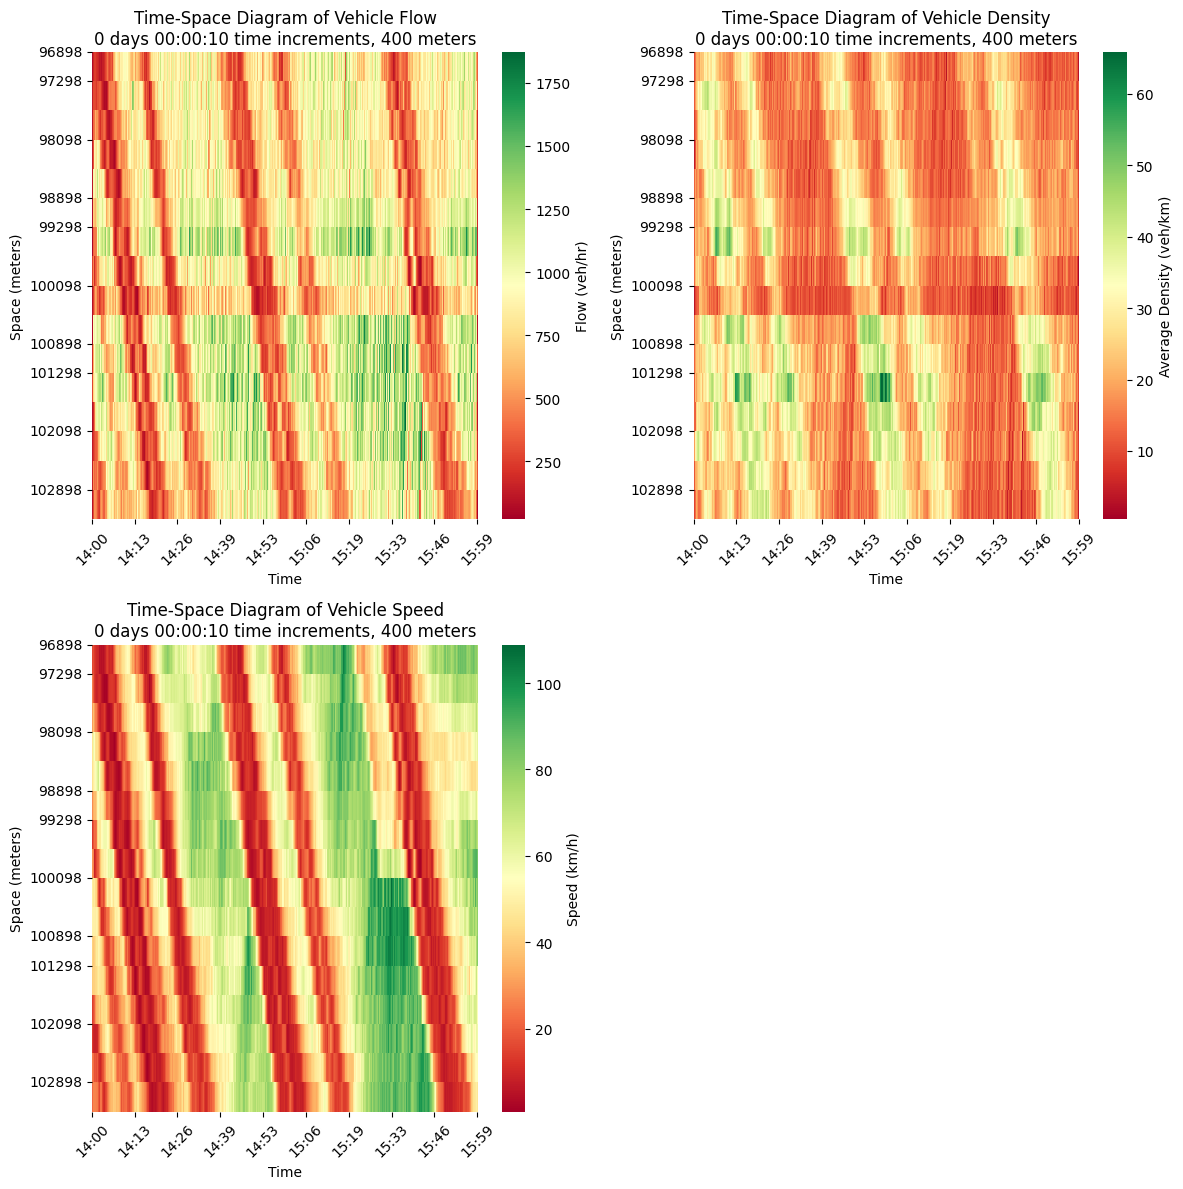

In [141]:
flow_10sec_100m_1hr, density_10sec_100m = get_flow_density_matrix(westbound_trajectories_1_hr_df, westbound_lane_func, time_interval = pd.Timedelta(seconds=5), space_interval = 200, output_filename="5sec_200_m_flow_speed_1hr.csv")
t_min, t_max = westbound_trajectories_1_hr_df["timestamp"].min(), westbound_trajectories_1_hr_df["timestamp"].max()
x_min, x_max = westbound_trajectories_1_hr_df["x_position"].min(), westbound_trajectories_1_hr_df["x_position"].max()
print(flow_10sec_100m_1hr.shape)
flow_10sec_100m_1hr = flow_10sec_100m_1hr[:,:-1]
flow_10sec_100m_1hr[:,5] = (flow_10sec_100m_1hr[:,4] + flow_10sec_100m_1hr[:,6])/2

flow_10sec_100m_1hr = np.flip(flow_10sec_100m_1hr, axis=1)
density_10sec_100m = density_10sec_100m[:,:-1]
mask = density_10sec_100m == 0
density_10sec_100m[mask] = 1e-3
density_10sec_100m[:,5] = (density_10sec_100m[:,4] + density_10sec_100m[:,6])/2
density_10sec_100m = np.flip(density_10sec_100m, axis=1)
velocity_arr = flow_10sec_100m_1hr/density_10sec_100m
np.save("flow_5sec_200m_1hr.npy", flow_10sec_100m_1hr)
np.save("density_5sec_200m_1hr.npy", density_10sec_100m)
np.save("velocity_5sec_200m_1hr.npy", velocity_arr)

plot_matrices(np.flip(flow_10sec_100m_1hr, axis=1), np.flip(density_10sec_100m, axis=1), pd.Timedelta(seconds=10), 400,  t_min, t_max, x_min, x_max)


In [142]:
from math import floor
wb_OH_on_start = 62.29 * 5280 * 0.3048
wb_OH_on_end = 61.51 * 5280 * 0.3048
wb_HH_off_start = 60.52 * 5280 * 0.3048
wb_HH_off_end = 60.21 * 5280 * 0.3048
POLE_24 = (150 - 86.63602)* 5280 * 0.3048
POLE_25 = (150 - 86.63386)* 5280 * 0.3048
print(floor(wb_OH_on_start), "wb_OH_on_start")
print(wb_OH_on_end, "wb_OH_on_end")
print(wb_HH_off_start, "wb_HH_off_start")
xmax_meters = 100246.04
xmin_meters = 96898.6
wb_OH_on_start_bin = (xmax_meters - xmin_meters) // 9
print(wb_OH_on_start_bin)
print((xmax_meters - floor(wb_OH_on_start)) // wb_OH_on_start_bin)
print((xmax_meters - floor(wb_OH_on_end)) // wb_OH_on_start_bin)
print((xmax_meters - floor(wb_HH_off_start)) //wb_OH_on_start_bin)

100246 wb_OH_on_start
98990.74944 wb_OH_on_end
97397.49888000001 wb_HH_off_start
371.0
0.0
3.0
7.0


In [143]:
def westbound_lane_func(space_bin):
    if space_bin >= 0 and space_bin <= 2:
        return 5
    if space_bin >= 3 and space_bin <= 6:
        return 4
    else:
        return 5

xmax 100246.04
x_min 96898.6
CSV file saved as data/10sec_400_m_flow_speed_1hr.csv


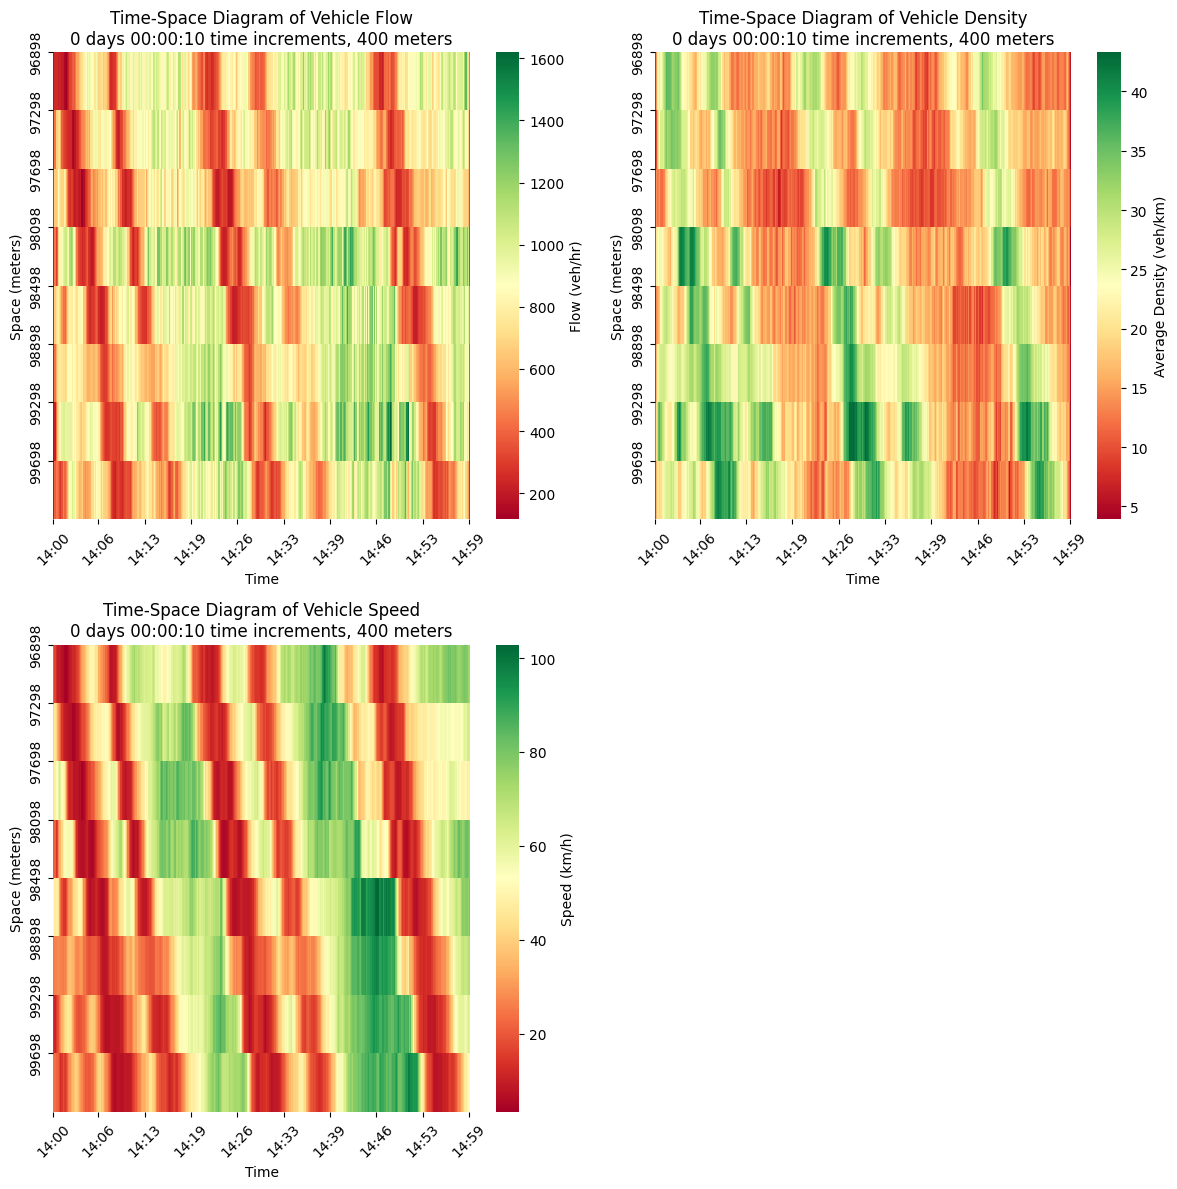

In [144]:
flow_10sec_100m_1hr, density_10sec_100m = get_flow_density_matrix(westbound_trajectories_1_hr_df, westbound_lane_func, time_interval = pd.Timedelta(seconds=10), space_interval = 400, output_filename="10sec_400_m_flow_speed_1hr.csv")
t_min, t_max = westbound_trajectories_1_hr_df["timestamp"].min(), westbound_trajectories_1_hr_df["timestamp"].max()
x_min, x_max = westbound_trajectories_1_hr_df["x_position"].min(), westbound_trajectories_1_hr_df["x_position"].max()
# x_max -=400
flow_10sec_100m_1hr = flow_10sec_100m_1hr[:,:-1]
flow_10sec_100m_1hr = np.flip(flow_10sec_100m_1hr, axis=1)
flow_10sec_100m_1hr[:, 2] = (flow_10sec_100m_1hr[:, 1] + flow_10sec_100m_1hr[:, 3])/2

density_10sec_100m = density_10sec_100m[:,:-1]
density_10sec_100m = np.flip(density_10sec_100m, axis=1)
density_10sec_100m[:, 2] = (density_10sec_100m[:, 1] + density_10sec_100m[:, 3])/2
velocity_arr = flow_10sec_100m_1hr/density_10sec_100m
np.save("flow_10sec_400m_1hr.npy", flow_10sec_100m_1hr)
np.save("density_10sec_400m_1hr.npy", density_10sec_100m)
np.save("velocity_10sec_400m_1hr.npy", velocity_arr)

plot_matrices(np.flip(flow_10sec_100m_1hr, axis=1), np.flip(density_10sec_100m, axis=1), pd.Timedelta(seconds=10), 400,  t_min, t_max, x_min, x_max)


xmax 100246.04
x_min 96898.6
CSV file saved as data/60sec_400_m_flow_speed_1hr.csv
(60, 8)


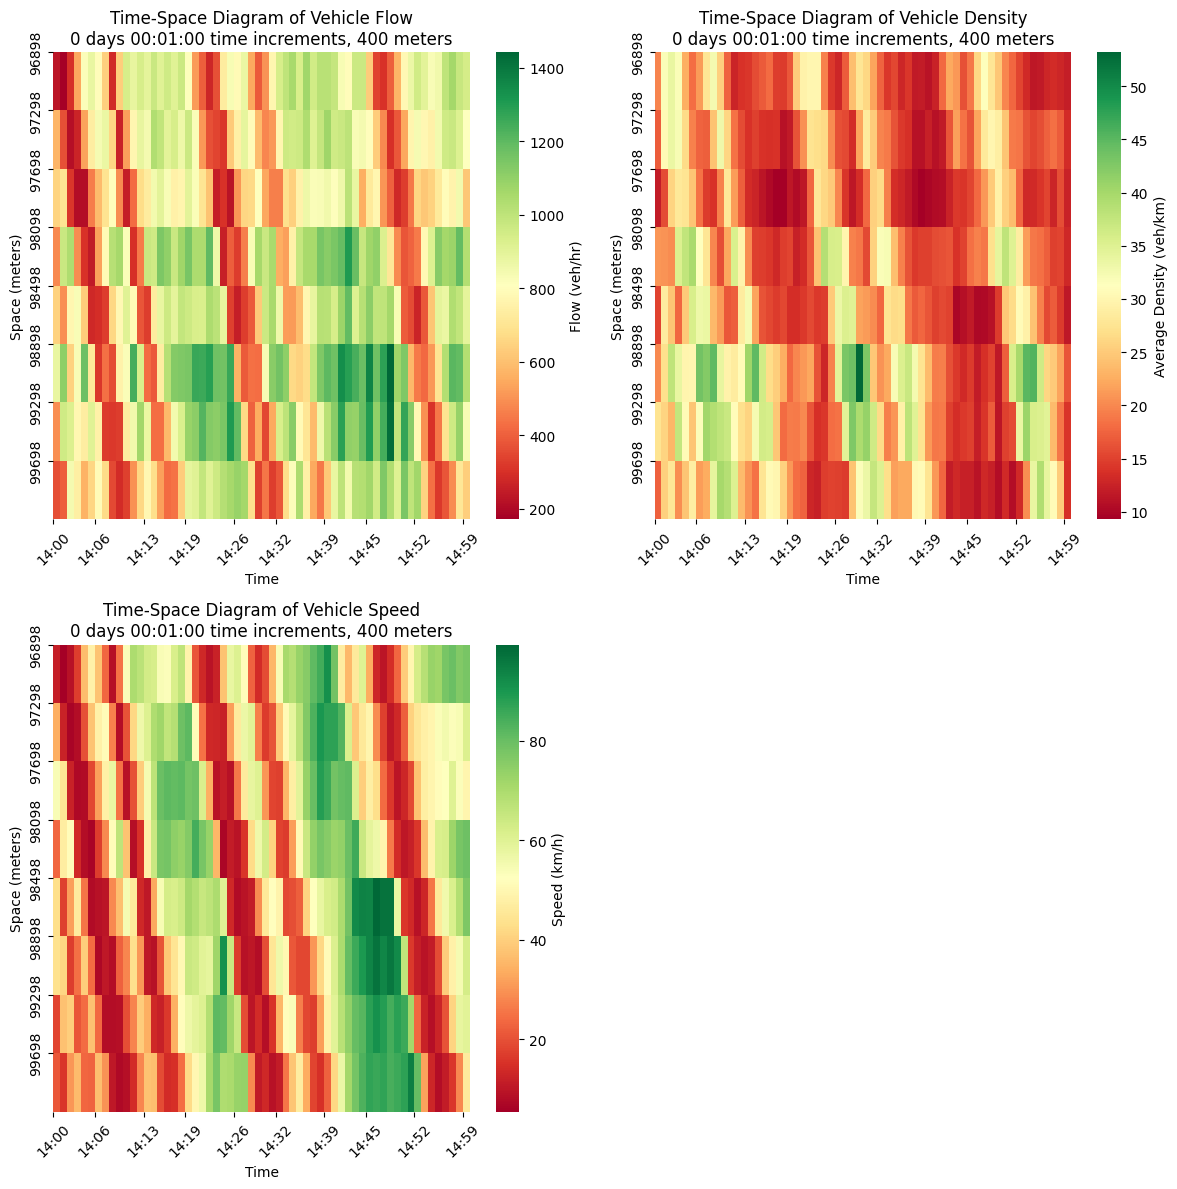

In [151]:
flow_10sec_100m_1hr, density_10sec_100m = get_flow_density_matrix(westbound_trajectories_1_hr_df, westbound_lane_func, time_interval = pd.Timedelta(seconds=60), space_interval = 400, output_filename="60sec_400_m_flow_speed_1hr.csv")
t_min, t_max = westbound_trajectories_1_hr_df["timestamp"].min(), westbound_trajectories_1_hr_df["timestamp"].max()
x_min, x_max = westbound_trajectories_1_hr_df["x_position"].min(), westbound_trajectories_1_hr_df["x_position"].max()
flow_10sec_100m_1hr = np.flip(flow_10sec_100m_1hr, axis=1)
density_10sec_100m = np.flip(density_10sec_100m, axis=1)
flow_10sec_100m_1hr = flow_10sec_100m_1hr[:,1:]
density_10sec_100m = density_10sec_100m[:,1:]
# density_10sec_100m[:, 2] = (density_10sec_100m[:, 1] + density_10sec_100m[:, 3])/2
velocity_arr = flow_10sec_100m_1hr/density_10sec_100m
np.save("flow_60sec_400m_1hr.npy", flow_10sec_100m_1hr)
np.save("density_60sec_400m_1hr.npy", density_10sec_100m)
np.save("velocity_60sec_400m_1hr.npy", velocity_arr)
print(velocity_arr.shape)
plot_matrices(np.flip(flow_10sec_100m_1hr, axis=1), np.flip(density_10sec_100m, axis=1), pd.Timedelta(seconds=60), 400,  t_min, t_max, x_min, x_max)
